In [2]:

import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow.keras as tfk
import xlrd
import numpy as np
import nltk
from nltk.corpus import stopwords
import sys
import string
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8423314075017657475
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1416668364
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18279357451731415240
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


True

In [ ]:
###
# RUN ONLY ONE TIME, LOADS RAW DATA
###

train = xlrd.open_workbook('train_data_final.xlsx')
test = xlrd.open_workbook('test_data_mod.xlsx')
trainsheet = train.sheet_by_index(0)
testsheet = test.sheet_by_index(0)
pub = []
pub_t = []
content = []
content_t = []
indeces = list(range(trainsheet.nrows -1))
indeces_t = list(range(testsheet.nrows -1))
np.random.shuffle(indeces)
for r in indeces:
    pub.append(trainsheet.cell_value(r,0))
    content.append(trainsheet.cell_value(r,1))
for r in indeces_t:
    pub_t.append(testsheet.cell_value(r,0))
    content_t.append(testsheet.cell_value(r,1))

In [3]:
stop = stopwords.words('english')
vocab = 50000


In [ ]:
###
# RUN ONE TIME, WRITES PROCESSED DATA TO FILES TO SAVE TIME 
###
content_arrs = []
content_arrs_t = []
content_arrs = []
content_arrs_t = []

contentFile = open("content.txt", "w+")
contentFile_t = open("content_t.txt", "w+")
pubFile = open("pub.txt", "w+")
pubFile_t = open("pub_t.txt", "w+")
for i in range(len(content)):
    con = content[i]
    contentClean = ' '.join([word for word in nltk.word_tokenize(con.lower()) if word not in stop and (word.isalpha() or len(word) > 1)])
    oneHot = tfk.preprocessing.text.one_hot(contentClean, n=vocab)
    content_arrs.append(oneHot)
    for d in oneHot:
        contentFile.write('%d ' % d)
    contentFile.write('\n')
    pubFile.write('%s\n' % pub[i])
    sys.stdout.write("\r" + str(i))
    sys.stdout.flush()
    
for i in range(len(content_t)):
    con = content_t[i]
    contentClean = ' '.join([word for word in nltk.word_tokenize(con.lower()) if word not in stop and (word.isalpha() or len(word) > 1)])
    oneHot = tfk.preprocessing.text.one_hot(contentClean, n=vocab)
    for d in oneHot:
        contentFile_t.write('%d ' % d)
    contentFile_t.write('\n')
    pubFile_t.write('%s\n' % pub_t[i])
    content_arrs_t.append(oneHot)
    sys.stdout.write("\r" + str(i))
    sys.stdout.flush()

    
contentFile.close()
contentFile_t.close()
pubFile.close()
pubFile_t.close()

In [4]:
# LOAD FROM PRREPROCESSED DATA
content_arrs = []
content_arrs_t = []
contentFile = open("content.txt")
content_arrs = contentFile.readlines()
contentFile_t = open("content_t.txt")
content_arrs_t = contentFile_t.readlines()
pubFile = open("pub.txt")
pubFile_t = open("pub_t.txt")

pub = pubFile.readlines()
pub_t = pubFile_t.readlines()
for i in range(len(content_arrs)):
    content_arrs[i] = content_arrs[i].split(' ')[0:-1]
    for j in range(len(content_arrs[i])):
        content_arrs[i][j] = float(content_arrs[i][j])
        
for i in range(len(content_arrs_t)):
    content_arrs_t[i] = content_arrs_t[i].split(' ')[0:-1]
    for j in range(len(content_arrs_t[i])):
        content_arrs_t[i][j] = float(content_arrs_t[i][j])


In [23]:
# MAPS A NUMBER TO EACH PUBLICATION FOR USE w/ to_categorical
targetMap = dict([(y,x) for x,y in enumerate(sorted(set(pub)))])
print(targetMap)
for i in range(len(pub)):
    pub[i] = targetMap[pub[i]]

for i in range(len(pub_t)):
    pub_t[i] = targetMap[pub_t[i]]

{'Atlantic\n': 0, 'Breitbart\n': 1, 'Business Insider\n': 2, 'Buzzfeed News\n': 3, 'CNN\n': 4, 'Fox News\n': 5, 'Guardian\n': 6, 'NPR\n': 7, 'National Review\n': 8, 'New York Post\n': 9, 'New York Times\n': 10, 'Reuters\n': 11, 'Talking Points Memo\n': 12, 'Vox\n': 13, 'Washington Post\n': 14}


In [24]:
long = 0
for con in content_arrs:
    if len(con) > long:
        long = len(con)
        
for con in content_arrs_t:
    if len(con) > long:
        long = len(con)
long = 750 # Sets max length to prevent GPU memory exhaustion (used across the board)
padded_arrs = tfk.preprocessing.sequence.pad_sequences(content_arrs, maxlen=long, padding='post')
padded_arrs_t = tfk.preprocessing.sequence.pad_sequences(content_arrs_t, maxlen=long, padding='post')


In [36]:
# Base RNN Model
model = tfk.models.Sequential()
model.add(tfk.layers.Embedding(vocab, 100, input_length=long))
model.add(tfk.layers.Dropout(.3))
model.add(tfk.layers.CuDNNGRU(40, return_sequences=True))
model.add(tfk.layers.CuDNNGRU(40))
model.add(tfk.layers.Dropout(.3))
model.add(tfk.layers.Dense(64, activation = 'relu'))
model.add(tfk.layers.Dense(15, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# Base CNN Model
model = tfk.models.Sequential()
model.add(tfk.layers.Embedding(vocab, 100, input_length=long))
model.add(tfk.layers.Conv1D(128, 1, activation = 'relu'))
model.add(tfk.layers.MaxPooling1D(1))
model.add(tfk.layers.Conv1D(128, 5, activation = 'relu'))
model.add(tfk.layers.MaxPooling1D(5))
model.add(tfk.layers.Conv1D(128, 5, activation = 'relu'))
model.add(tfk.layers.MaxPooling1D(25)) # Corresponds w/ max length as global maxpool
model.add(tfk.layers.Flatten())
model.add(tfk.layers.Dense(128, activation = 'relu'))
model.add(tfk.layers.Dense(15, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [ ]:
weights = model.get_weights()

In [37]:
print('Begin fit')
print(np.shape(padded_arrs))
print(padded_arrs)
history = model.fit(padded_arrs, tfk.utils.to_categorical(pub), batch_size=50, epochs=3, validation_split=0.2, shuffle=True, verbose=1)

Begin fit
(98711, 750)
[[23548 32894 34723 ...     0     0     0]
 [ 1092 20251 32562 ...     0     0     0]
 [20251 38160 34520 ...     0     0     0]
 ...
 [17774 31599 38589 ...     0     0     0]
 [  354  7786  2853 ...     0     0     0]
 [16961 45171 43849 ...     0     0     0]]
Train on 78968 samples, validate on 19743 samples
Epoch 1/3
78968/78968 [==============================] - 51s 649us/sample - loss: 1.2545 - acc: 0.6057 - val_loss: 0.9333 - val_acc: 0.7107
Epoch 2/3
78968/78968 [==============================] - 50s 636us/sample - loss: 0.1737 - acc: 0.9513 - val_loss: 1.1778 - val_acc: 0.6835
Epoch 3/3
78968/78968 [==============================] - 49s 621us/sample - loss: 0.0179 - acc: 0.9968 - val_loss: 1.4014 - val_acc: 0.6853


In [ ]:
model.set_weights(weights) # make sure weights are always reinitialized

In [27]:
loss, accuracy = model.evaluate(padded_arrs_t, tfk.utils.to_categorical(pub_t), verbose=1)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss))

43732/43732 [==============================] - 49s 1ms/sample - loss: 0.6816 - acc: 0.7941
Accuracy: 79.413247
Loss: 0.681578


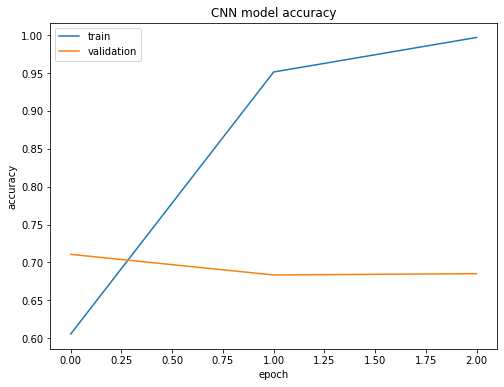

[0.6057137, 0.9512587, 0.9968088]
[0.71073294, 0.68353343, 0.6852555]
[1.2545048947635784, 0.17366408200167657, 0.017929908796978093]
[0.9333239869796559, 1.1777990363394484, 1.4014459850366299]


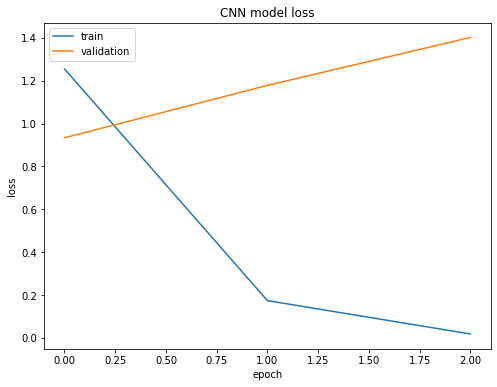

In [39]:
from matplotlib import pyplot as plt
print(history)
plt.figure(figsize=(8,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(history.history['acc'])
print(history.history['val_acc'])
print(history.history['loss'])
print(history.history['val_loss'])
# summarize history for loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
